In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import cv2
import time
import copy
import numpy as np
import torch.optim as optim
import pytorchtools
import glob
import pathlib 
import random
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import DataLoader
from functools import partial
from bayes_opt import BayesianOptimization
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from PIL import Image
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pytorch_lightning import Trainer


C:\Users\Lenovo\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224),
    transforms.ColorJitter(2),
    transforms.ToTensor(),         
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [3]:
dataset = torchvision.datasets.ImageFolder(root='data', transform=transform)
len(dataset)

976

In [4]:
dataset.classes

['AiArtData', 'RealArt']

In [5]:
# Get current directory
cwd_path = pathlib.Path(os.getcwd())


In [6]:
# Define data directory
path_to_img_dir = os.path.join(cwd_path, 'data')


In [7]:

for dirname, _, filenames in os.walk(path_to_img_dir):
    for filename in filenames:
        img_path = os.path.join(dirname,filename)
        im = Image.open(img_path)
        # Check if the image is a PNG and not already in RGBA mode
        if im.format == 'PNG' and im.mode != 'RGBA':
            im = im.convert('RGBA')
            

In [8]:

class Dataset(Dataset):
    def __init__(self, root_dir, transform):
        self.transform = transform
        self.image_paths = []
        for ext in ['png', 'jpg', 'jpeg']:
            self.image_paths += glob.glob(os.path.join(root_dir, '*', f'*.{ext}'))
        class_set = set()
        for path in self.image_paths:
            class_set.add(os.path.dirname(path))
        self.class_lbl = { cls: i for i, cls in enumerate(sorted(list(class_set)))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = read_image(self.image_paths[idx], ImageReadMode.RGB).float()
        cls = os.path.basename(os.path.dirname(self.image_paths[idx]))
        label = self.class_lbl[cls]

        return self.transform(img), torch.tensor(label)

In [9]:
custom_dataset = Dataset('data/', transform)

In [10]:
#Create data split ration
splits = [0.8, 0.1, 0.1]

In [11]:
split_sizes = []
for sp in splits[:-1]:
    split_sizes.append(int(sp * len(custom_dataset)))
split_sizes.append(len(dataset) - sum(split_sizes))

In [12]:
# Randomly split dataset into training, validation and test sets
train_set, test_set, val_set = torch.utils.data.random_split(dataset, split_sizes)

In [13]:
dataloaders = {
    "train": DataLoader(train_set, batch_size=32, shuffle=True),
    "test": DataLoader(test_set, batch_size=32, shuffle=False),
    "val": DataLoader(val_set, batch_size=32, shuffle=False)
}

In [14]:
# Extract train_loader, val_loader and test_loader from dataloader dictionary
train_loader = dataloaders['train'].dataset
val_loader = dataloaders['val'].dataset
test_loader = dataloaders['test'].dataset

In [15]:
image , label = next(iter(train_loader))

In [16]:
# Create an AdaptiveAvgPool2d layer with target output size (224, 224)
adaptive_avg_pool = nn.AdaptiveAvgPool2d((224, 224))
# Apply the adaptive pooling layer to the input tensor
output_tensor = adaptive_avg_pool(image)

In [17]:
#Determine image shape from the adaptive pool tensor
image = output_tensor
image_shape = image.shape
image_shape

torch.Size([3, 224, 224])

In [18]:
# CNN architecture based on Bayesian optimisation in the other notebook
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))  # Adaptive pooling to fixed size
        self.fc1 = nn.Linear(64 * 4 * 4, 77)
        self.fc2 = nn.Linear(77, 77)
        self.fc3 = nn.Linear(77, 1)
        self.dropout = nn.Dropout(p=0.17)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.adaptive_pool(x)  # Apply adaptive pooling
        x = x.view(-1, 64 * 4 * 4)  #Flatten Convolutional layer
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x

In [19]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [20]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs= []
all_preds, all_labels = [], []

In [21]:

# Create training loop
def train_step(model, train_dataset, val_dataset, loss_fn, optimizer, num_epochs=50):
    since = time.time()
    best_model_weight = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=5, verbose=True)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        model.train()
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        train_loss, train_correct = 0, 0

        for batch, (X, y) in enumerate(train_loader):
            y_pred = model(X).squeeze()
            loss = loss_fn(y_pred, y.float())
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_pred_class = (y_pred > 0.5).float()
            train_correct += (y_pred_class == y).sum().item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_acc = train_correct / len(train_loader.dataset)
        train_accuracies.append(train_acc)

        model.eval()
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
        val_loss, val_correct = 0, 0
        

        with torch.no_grad():
            for batch, (X, y) in enumerate(val_loader):
                y_pred = model(X).squeeze()
                loss = loss_fn(y_pred, y.float())
                val_loss += loss.item()
                y_pred_class = (y_pred > 0.5).float()
                val_correct += (y_pred_class == y).sum().item()
                all_preds.extend(y_pred_class.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_acc = val_correct / len(val_loader.dataset)
        val_accuracies.append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_weight = copy.deepcopy(model.state_dict())
            torch.save(best_model_weight, 'checkpoint.pt')

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        epochs.append(epoch)
    model.load_state_dict(best_model_weight)
    print('Training ends')

    end = time.time()
    duration = (end - since)/60
    print(f'Duration: {duration:.2f} minutes')




In [22]:
# Createan instance of the model
model = CNN()
model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc1): Linear(in_features=1024, out_features=77, bias=True)
  (fc2): Linear(in_features=77, out_features=77, bias=True)
  (fc3): Linear(in_features=77, out_features=1, bias=True)
  (dropout): Dropout(p=0.17, inplace=False)
)

In [23]:
# Define loss function and Optimizer
loss_fn = nn.BCELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
# Call the training to train the model
train_step(model, train_set, val_set, loss_fn, optimizer)

Epoch 0/49


C:\Users\Lenovo\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.6996, Train Acc: 0.5129
Val Loss: 0.6937, Val Acc: 0.5094
Epoch 1/49
Train Loss: 0.6891, Train Acc: 0.5930
Val Loss: 0.6915, Val Acc: 0.5377
Epoch 2/49
Train Loss: 0.6833, Train Acc: 0.5917
Val Loss: 0.6921, Val Acc: 0.5094
Epoch 3/49
Train Loss: 0.6725, Train Acc: 0.5827
Val Loss: 0.6919, Val Acc: 0.5189
Epoch 4/49
Train Loss: 0.6593, Train Acc: 0.6176
Val Loss: 0.7238, Val Acc: 0.5377
Epoch 5/49
Train Loss: 0.6437, Train Acc: 0.6279
Val Loss: 0.6856, Val Acc: 0.5849
Epoch 6/49
Train Loss: 0.6553, Train Acc: 0.6124
Val Loss: 0.6606, Val Acc: 0.5849
Epoch 7/49
Train Loss: 0.6579, Train Acc: 0.6150
Val Loss: 0.7002, Val Acc: 0.5189
Epoch 8/49
Train Loss: 0.6680, Train Acc: 0.6124
Val Loss: 0.7031, Val Acc: 0.5377
Epoch 9/49
Train Loss: 0.6589, Train Acc: 0.6124
Val Loss: 0.6701, Val Acc: 0.6226
Epoch 10/49
Train Loss: 0.6542, Train Acc: 0.6305
Val Loss: 0.6654, Val Acc: 0.6226
Epoch 11/49
Train Loss: 0.6283, Train Acc: 0.6550
Val Loss: 0.6968, Val Acc: 0.5849
Early stoppin

In [25]:
# Confusion Matrix
confusion_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(confusion_matrix)

Confusion Matrix:
[[571 101]
 [464 136]]


In [35]:
print(len(train_losses))
print(len(val_losses)) 
print(len(train_accuracies))
print(len(val_accuracies))
print(len(epochs))
print(len(all_preds)) 
print(len(all_labels))

12
12
12
12
11
1272
1272


In [ ]:
history = []
history.append({'epoch':epochs,'train_loss':training_losses,'val_loss':epoch_val_loss,'val_accuracy':epoch_accuracy})

Text(0.5, 1.0, 'Training Accuracies and  Loss')

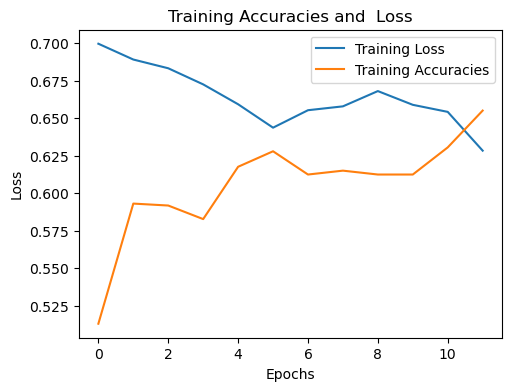

In [39]:
# Plot training accuracy and training loss
num_epochs=12
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Accuracies and  Loss')

Text(0.5, 1.0, 'Validation Accuracies and Loss')

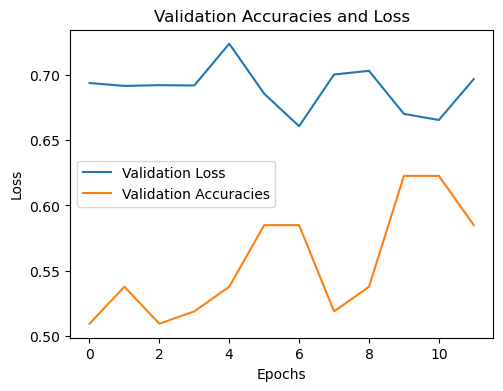

In [41]:
# Plot validation accuracy and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Accuracies and Loss')

In [45]:
# Function to inference over test data
def classify_test_images(model, test_loader):
    model.eval()  #set model to evaluation
    sample_images, sample_labels = next(iter(test_loader))  #iterate to next sample
    with torch.no_grad():
        predictions = model(sample_images).squeeze()
        predicted_classes = (predictions > 0.5).float()
    return sample_images, predicted_classes, sample_labels


In [87]:
# Inference on a test data sample
sample_images, predicted_classes, sample_labels = classify_test_images(model, test_loader)

In [89]:
#predicted class
int(predicted_classes.item())

0

In [91]:
#Actual label
sample_labels

1

In [71]:
# Funtion to evaluate model on test set
def test_step(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / len(testloader)
    print(f"Test Accuracy: {accuracy:.2f}%")
    #return accuracy
  

In [73]:
test_step(model, test_loader)

Test Accuracy: 51.04%


In [93]:
# store weights into a local file
torch.save(model.state_dict(), 'checkpoint1.pth')
